# Alzheimer's prediction

## What is Alzheimer's disease (AD)?

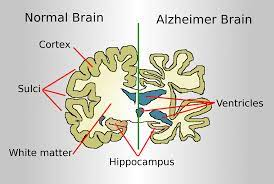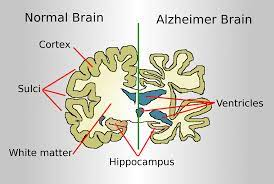

Alzheimer's disease (AD) is a neurodegenerative disease that usually starts slowly and progressively worsens.It is the cause of 60–70% of cases of dementia.The most common early symptom is difficulty in remembering recent events. As the disease advances, symptoms can include problems with language, disorientation (including easily getting lost), mood swings, loss of motivation, self-neglect, and behavioral issues. As a person's condition declines, they often withdraw from family and society.Gradually, bodily functions are lost, ultimately leading to death. Although the speed of progression can vary, the typical life expectancy following diagnosis is three to nine years.

## What is Dementia?

Dementia is a general term for loss of memory, language, problem-solving and other thinking abilities that are severe enough to interfere with daily life. Alzheimer's is the most common cause of dementia, a general term for memory loss and other cognitive abilities serious enough to interfere with daily life. Alzheimer's disease accounts for 60-80% of dementia cases.

### Our problem statement

Estimating the CDR (scale of Dementia) using relevant features in the MRI dataset.

The CDR is based on a scale of 0–3: no dementia (CDR = 0), questionable dementia (CDR = 0.5), MCI (CDR = 1), moderate cognitive impairment (CDR = 2), and severe cognitive impairment (CDR = 3).

In [1]:
import tensorflow.compat.v1 as tf
from sklearn.metrics import confusion_matrix
import numpy as np
from scipy.io import loadmat
from pywt import wavedec
from functools import reduce
from scipy import signal
from scipy.stats import entropy
from scipy.fft import fft, ifft
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from tensorflow import keras as K
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold,cross_validate
from tensorflow.keras.layers import Dense, Activation, Flatten, concatenate, Input, Dropout, LSTM, Bidirectional,BatchNormalization,PReLU,ReLU,Reshape
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential, Model, load_model
import matplotlib.pyplot as plt;
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from tensorflow.keras.layers import Conv1D,Conv2D,Add
from tensorflow.keras.layers import MaxPool1D, MaxPooling2D
import seaborn as sns

2021-09-14 05:44:52.598261: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


## Reading the Cross-sectional and Longitudinal MRI datasets.

We describe the attributes in the dataset with data_cross.info() and data_long.info()

In [ ]:
data_cross = pd.read_csv("../input/mri-and-alzheimers/oasis_cross-sectional.csv")
data_long = pd.read_csv("../input/mri-and-alzheimers/oasis_longitudinal.csv")
print(data_cross.info())
print(data_long.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 436 entries, 0 to 435
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      436 non-null    object 
 1   M/F     436 non-null    object 
 2   Hand    436 non-null    object 
 3   Age     436 non-null    int64  
 4   Educ    235 non-null    float64
 5   SES     216 non-null    float64
 6   MMSE    235 non-null    float64
 7   CDR     235 non-null    float64
 8   eTIV    436 non-null    int64  
 9   nWBV    436 non-null    float64
 10  ASF     436 non-null    float64
 11  Delay   20 non-null     float64
dtypes: float64(7), int64(2), object(3)
memory usage: 41.0+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373 entries, 0 to 372
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Subject ID  373 non-null    object 
 1   MRI ID      373 non-null    object 
 2   Group       373 non-null    object 

In [ ]:
print(data_cross.isna().sum())
print("\n")
data_long.isna().sum()

## Data Cleaning
Checking for null values.

In [3]:
print(data_cross.isna().sum())
print("\n")
data_long.isna().sum()

ID         0
M/F        0
Hand       0
Age        0
Educ     201
SES      220
MMSE     201
CDR      201
eTIV       0
nWBV       0
ASF        0
Delay    416
dtype: int64




Subject ID     0
MRI ID         0
Group          0
Visit          0
MR Delay       0
M/F            0
Hand           0
Age            0
EDUC           0
SES           19
MMSE           2
CDR            0
eTIV           0
nWBV           0
ASF            0
dtype: int64

Since we will be predicting on the variable "CDR", we drop all the rows with undefined or null values

In [4]:
data_cross.dropna(subset=['CDR'],inplace=True)

## Removing unnecessary columns in both datasets.
The unique columns would be of no use in estimating the dependent variable "CDR"

In [5]:
data_cross.drop(columns=['ID','Delay'],inplace=True)
data_long = data_long.rename(columns={'EDUC':'Educ'})
data_long.drop(columns=['Subject ID','MRI ID','Group','Visit','MR Delay'],inplace=True)

## Appending both the datasets.

In [6]:
data = pd.concat([data_cross,data_long])
data.head()

M/F Hand  Age  Educ  SES  MMSE  CDR  eTIV   nWBV    ASF
0   F    R   74   2.0  3.0  29.0  0.0  1344  0.743  1.306
1   F    R   55   4.0  1.0  29.0  0.0  1147  0.810  1.531
2   F    R   73   4.0  3.0  27.0  0.5  1454  0.708  1.207
8   M    R   74   5.0  2.0  30.0  0.0  1636  0.689  1.073
9   F    R   52   3.0  2.0  30.0  0.0  1321  0.827  1.329

In [7]:
data.describe()

Age        Educ        SES        MMSE         CDR         eTIV  \
count  608.000000  608.000000  570.00000  606.000000  608.000000   608.000000   
mean    75.208882   10.184211    2.47193   27.234323    0.288651  1477.062500   
std      9.865026    6.058388    1.12805    3.687980    0.377697   170.653795   
min     33.000000    1.000000    1.00000    4.000000    0.000000  1106.000000   
25%     70.000000    4.000000    2.00000   26.000000    0.000000  1352.500000   
50%     76.000000   12.000000    2.00000   29.000000    0.000000  1460.000000   
75%     82.000000   16.000000    3.00000   30.000000    0.500000  1569.000000   
max     98.000000   23.000000    5.00000   30.000000    2.000000  2004.000000   

            nWBV         ASF  
count  608.00000  608.000000  
mean     0.73713    1.203597  
std      0.04267    0.135091  
min      0.64400    0.876000  
25%      0.70400    1.118000  
50%      0.73600    1.202000  
75%      0.76625    1.297500  
max      0.84700    1.587000

<AxesSubplot:>

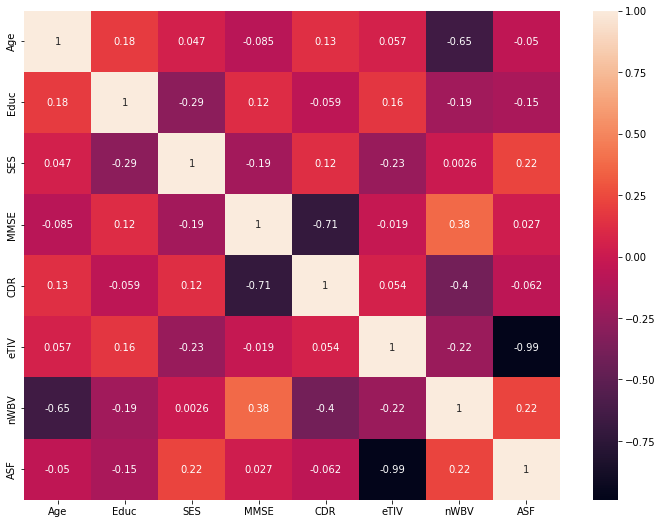

In [8]:
cor = data.corr()
plt.figure(figsize=(12,9))
sns.heatmap(cor, xticklabels=cor.columns.values,yticklabels=cor.columns.values, annot=True)


In [ ]:
import pandas_profiling as pp
pp.ProfileReport(data)

## Using Pandas_Profiling to analyze the correlation between variables.

In [9]:
import pandas_profiling as pp
pp.ProfileReport(data)

Summarize dataset:   0%|          | 0/24 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [10]:
data.isna().sum()

M/F      0
Hand     0
Age      0
Educ     0
SES     38
MMSE     2
CDR      0
eTIV     0
nWBV     0
ASF      0
dtype: int64

## Imputing columns using SimpleImputer.
We fill in the missing values in the "SES" columns with the most occuring data element.
Similarly, we fill the missing values in the "MMSE" column with the median of that column.

In [11]:
from sklearn.impute  import SimpleImputer
imputer = SimpleImputer ( missing_values = np.nan,strategy='most_frequent')

imputer.fit(data[['SES']])
data[['SES']] = imputer.fit_transform(data[['SES']])

# We perform it with the median
imputer = SimpleImputer ( missing_values = np.nan,strategy='median')

imputer.fit(data[['MMSE']])
data[['MMSE']] = imputer.fit_transform(data[['MMSE']])

In [12]:
data

M/F Hand  Age  Educ  SES  MMSE  CDR  eTIV   nWBV    ASF
0     F    R   74   2.0  3.0  29.0  0.0  1344  0.743  1.306
1     F    R   55   4.0  1.0  29.0  0.0  1147  0.810  1.531
2     F    R   73   4.0  3.0  27.0  0.5  1454  0.708  1.207
8     M    R   74   5.0  2.0  30.0  0.0  1636  0.689  1.073
9     F    R   52   3.0  2.0  30.0  0.0  1321  0.827  1.329
..   ..  ...  ...   ...  ...   ...  ...   ...    ...    ...
368   M    R   82  16.0  1.0  28.0  0.5  1693  0.694  1.037
369   M    R   86  16.0  1.0  26.0  0.5  1688  0.675  1.040
370   F    R   61  13.0  2.0  30.0  0.0  1319  0.801  1.331
371   F    R   63  13.0  2.0  30.0  0.0  1327  0.796  1.323
372   F    R   65  13.0  2.0  30.0  0.0  1333  0.801  1.317

[608 rows x 10 columns]

## Encoding the Target variable using LabelEncoder.

In [13]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
data['CDR'] = le.fit_transform(data['CDR'].values)

In [ ]:
data = pd.get_dummies(data)

Converting categorical variables to numeric using OneHot encoding.

In [14]:
data = pd.get_dummies(data)

## Plotting the distribution of classes on a barplot.

<BarContainer object of 4 artists>

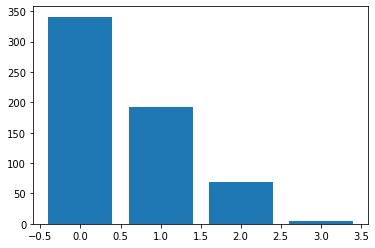

In [15]:
plt.bar(data['CDR'].unique(),data['CDR'].value_counts())

Neglecting the last class due to negligible size in the combined dataset.

In [16]:
data = data.drop(data[data['CDR']==3].index)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 599 entries, 0 to 372
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Age     599 non-null    int64  
 1   Educ    599 non-null    float64
 2   SES     599 non-null    float64
 3   MMSE    599 non-null    float64
 4   CDR     599 non-null    int64  
 5   eTIV    599 non-null    int64  
 6   nWBV    599 non-null    float64
 7   ASF     599 non-null    float64
 8   M/F_F   599 non-null    uint8  
 9   M/F_M   599 non-null    uint8  
 10  Hand_R  599 non-null    uint8  
dtypes: float64(5), int64(3), uint8(3)
memory usage: 43.9 KB


In [17]:
y = data.pop('CDR')
x = data

## Normalizing the data.
We observe that different columns have different ranges of values. We use Z-score normalization in this case.

In [18]:
x = StandardScaler().fit_transform(x)

## Dividing dataset into train and test sets.

In [19]:
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state = 42,test_size=0.3)

## Defining Models.

### 1. We will try hyperparameter tuning using cross-validation for XGBClassifier.

In [20]:
from xgboost import XGBClassifier
FOLDS = 5

parametros_xgb = {
    "learning_rate": [0.01, 0.025, 0.005,0.5, 0.075, 0.1, 0.15, 0.2,0.3,0.8,0.9],
    "max_depth":[3,5,8,10,15,20,25,30,40,50],
    "n_estimators":range(1,1000)
    }

model_xgb= XGBClassifier(eval_metric='mlogloss')


xgb_random = RandomizedSearchCV(estimator = model_xgb, param_distributions = parametros_xgb, n_iter = 100, cv = FOLDS, 
                               verbose=0, random_state=42,n_jobs = -1, scoring='accuracy')
xgb_random.fit(X_train, y_train)

xgb_random.best_params_

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing X

{'n_estimators': 583, 'max_depth': 5, 'learning_rate': 0.5}

In [21]:
model_xgb = xgb_random.best_estimator_
model_xgb.fit(X_train,y_train)
model_xgb.score(X_test,y_test)

0.7722222222222223

### 2. Trying hyperparameter tuning of GradientBoostingClassifier.

In [22]:
from sklearn.ensemble import GradientBoostingClassifier
FOLDS =10

parametros_gb = {
    "loss":["deviance"],
    "learning_rate": [0.01, 0.025, 0.005,0.5, 0.075, 0.1, 0.15, 0.2,0.3,0.8,0.9],
    "min_samples_split": [0.01, 0.025, 0.005,0.4,0.5, 0.075, 0.1, 0.15, 0.2,0.3,0.8,0.9],
    "min_samples_leaf": [1,2,3,5,8,10,15,20,40,50,55,60,65,70,80,85,90,100],
    "max_depth":[3,5,8,10,15,20,25,30,40,50],
    "max_features":["log2","sqrt"],
    "criterion": ["friedman_mse",  "mae"],
    "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    "n_estimators":range(1,100)
    }

model_gb= GradientBoostingClassifier()


gb_random = RandomizedSearchCV(estimator = model_gb, param_distributions = parametros_gb, n_iter = 100, cv = FOLDS, 
                               verbose=0, random_state=42,n_jobs = -1, scoring='accuracy')
gb_random.fit(X_train, y_train)

gb_random.best_params_

{'subsample': 0.95,
 'n_estimators': 96,
 'min_samples_split': 0.15,
 'min_samples_leaf': 5,
 'max_features': 'log2',
 'max_depth': 50,
 'loss': 'deviance',
 'learning_rate': 0.15,
 'criterion': 'friedman_mse'}

In [23]:
model_gb = gb_random.best_estimator_
print(model_gb.score(X_test,y_test))

0.7722222222222223


GradientBoosting model performs better than XGboost, Hence we try 10-fold cross validation on GradientBoostingClassifier model to improve accuracy.

In [24]:
cross_val_score(model_gb, x, y, cv=10, scoring='accuracy').mean()

0.8063559322033897

### Making predictions using the best estimator and plotting the confusion matrix along with classification report.

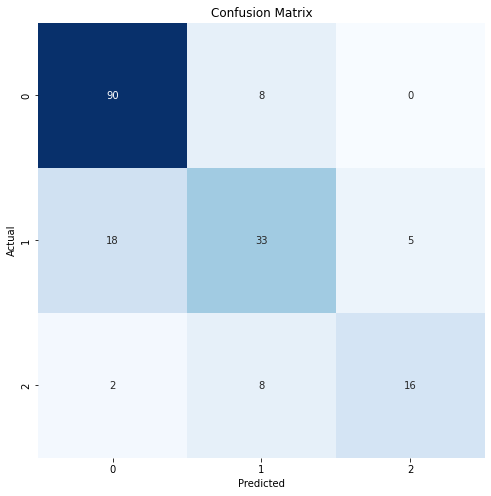

Classification Report:
----------------------
               precision    recall  f1-score   support

           0       0.82      0.92      0.87        98
           1       0.67      0.59      0.63        56
           2       0.76      0.62      0.68        26

    accuracy                           0.77       180
   macro avg       0.75      0.71      0.72       180
weighted avg       0.77      0.77      0.77       180



In [25]:
y_pred = model_gb.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
clr = classification_report(y_test, y_pred)

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cbar=False, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n----------------------\n", clr)
